# 04 - Clustering

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import os
import matplotlib.animation as animation

from models.BRUTAL_X_RCC import XRCC#, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
from IPython.display import display

In [6]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 2628

learning_rate   = 5
min_len         = 10
mode            = 'single'
starting_bp     = [50, 330]

overwrite_results = True

In [7]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Path for results
results_path_file   = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.nc'
results_path_image  = f'../data/results/images/clustering_results_{n_seasons}seas_{n_iters}iters_ERA5.png'

if os.path.exists(results_path_file) and overwrite_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not overwrite_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

In [8]:
if not os.path.exists(results_path_file) or overwrite_results:

    dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load()
    dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load()
    dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load()
    dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load()

    dataset_tp['time'] = dataset_t2m['time']
    dataset_u100['time'] = dataset_t2m['time']
    dataset_v100['time'] = dataset_t2m['time']

    datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

    clustering_params = {
        'iters': n_iters,
        'n_seas': n_seasons,
        'learning_rate': learning_rate,
        'min_len': min_len,
        'mode': mode,
        'starting_bp': starting_bp,
    }

    breakpoints, error_history_da, silhouette_scores_da = XRCC(datasets, **clustering_params)

else:
    result = xr.open_dataset(results_path_file).__xarray_dataarray_variable__

2628it [00:01, 1381.16it/s]
2628it [00:01, 1392.43it/s]
2628it [00:01, 1393.22it/s]
2628it [00:01, 1394.84it/s]
2628it [00:01, 1395.11it/s]
2628it [00:01, 1402.36it/s]


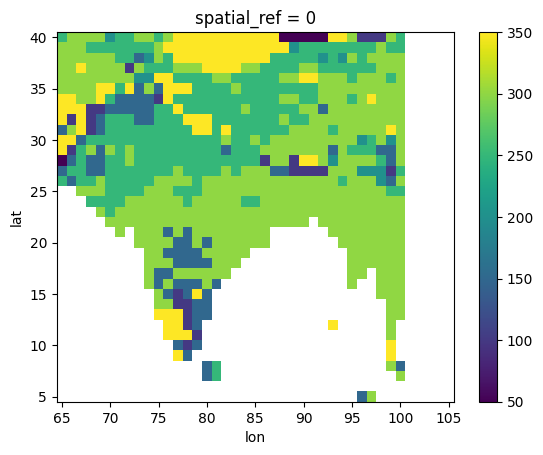

In [39]:
breakpoints.sel(cluster=1).plot()

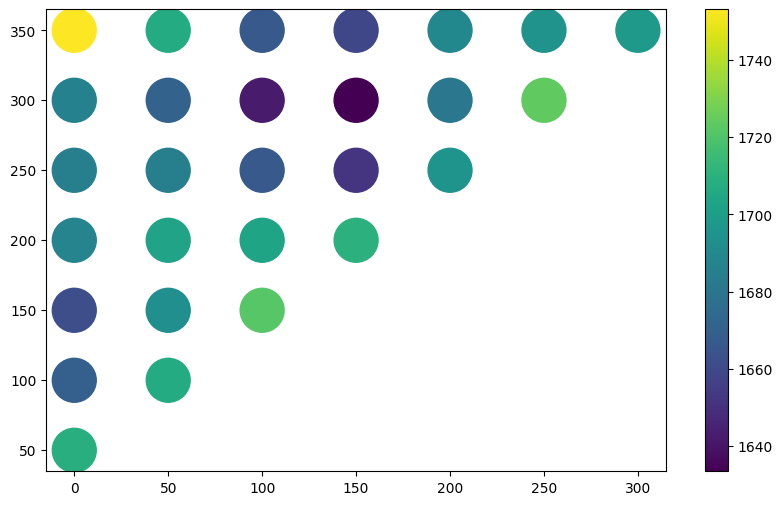

In [34]:
from itertools import combinations

n_days = list(np.arange(0,365,50))

x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

z = error_history_da.mean(['lat', 'lon']).values

#make this but as imshow
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(x, y, c=z, cmap='viridis', s=1000)

plt.colorbar(sc)



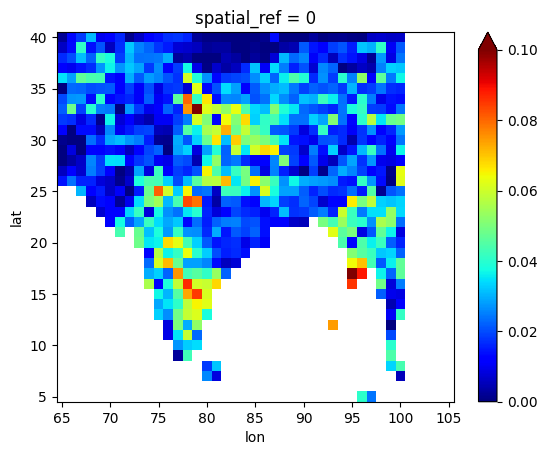

In [24]:
(silhouette_scores_da.isel(iter = -1) - silhouette_scores_da.isel(iter = 0)).plot(vmin=0, vmax=0.1, extend='max', cmap='jet')

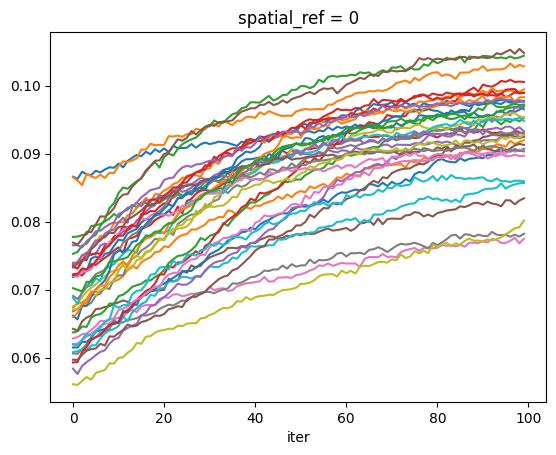

In [10]:
silhouette_scores_da.mean('lat').plot(hue='lon', add_legend=False)

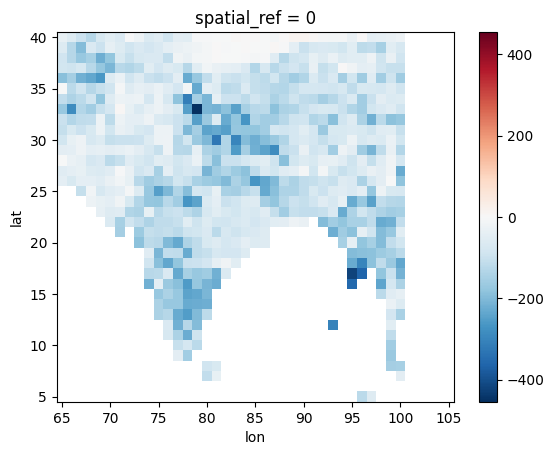

In [11]:
(error_history_da.isel(iter = -1) - error_history_da.isel(iter = 0)).plot()

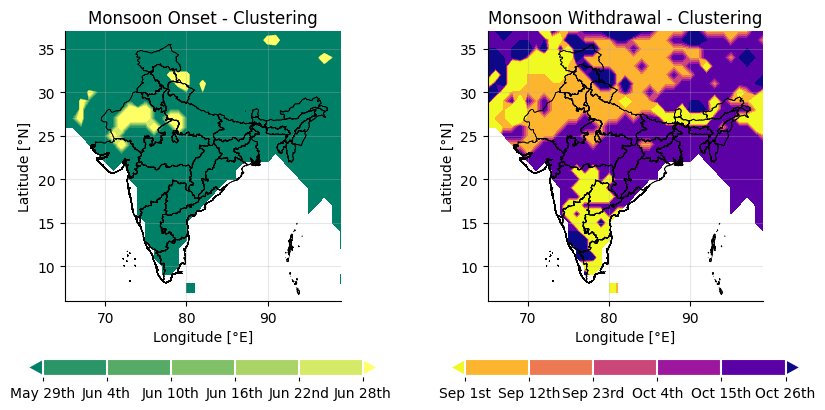

In [40]:
# Load country boundary data
# mask_boundary = gpd.read_file(world_boundary_file, layer='ADM_1')
# mask_boundary = mask_boundary[mask_boundary["GID_0"].isin(['IND','NPL','BGD'])]

# result_plot = result.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
# result_plot.rio.write_crs("epsg:4326", inplace=True)
# result_plot = result_plot.rio.clip(mask_boundary.geometry.apply(mapping), mask_boundary.crs, drop=True)

result_plot = breakpoints


plot_seasons_bk_results( result_plot, figsize=(10,5), cmaps=['summer', 'plasma_r'],
                         lims=[[150,180],[245,300]], titles=['Monsoon Onset - Clustering', 'Monsoon Withdrawal - Clustering'],
                         country_boundary=country_boundary, world_boundary=country_boundary)

# plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)

In [13]:
# if not os.path.exists(results_path_file) or overwrite_results:
    
#     result.attrs=dict(
#             Description="Dataset with seasonal onset dates obtained with Radially Constrained Clustering",
#             Parameters=(

#                 f"Number of seasons: {n_seasons}",
#                 f"Number of iterations: {n_iters}",
#                 f"Learning rate: {learning_rate}",
#                 f"Minimum length of seasons: {min_len}",
#                 f"Clustering mode: {mode}",
#                 f"Initializtion dates: {[day_of_year_to_date(x) for x in starting_bp]}",
        
#             )
#         )

#     result.to_netcdf(results_path_file)